In [2]:
#!/home/desktop/Desktop/project_AI/env/bin/python3
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta
from sklearn.preprocessing import RobustScaler
plt.style.use("bmh")

# Technical Analysis library
import ta

# Neural Network library
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Loading in the Data
df = pd.read_csv("history/market.csv")

## Datetime conversion
df['Date'] = pd.to_datetime(df.Date)

# Setting the index
df.set_index('Date', inplace=True)

# Dropping any NaNs
df.dropna(inplace=True)



## Technical Indicators

# Adding all the indicators
df = ta.add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

# Dropping everything else besides 'Close' and the Indicators
df.drop(['Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)

# Only using the last 1000 days of data to get a more accurate representation of the current market climate
df = df.tail(1000)



## Scaling

# Scale fitting the close prices separately for inverse_transformations purposes later
close_scaler = RobustScaler()

close_scaler.fit(df[['Close']])

# Normalizing/Scaling the DF
scaler = RobustScaler()

df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

FileNotFoundError: [Errno 2] No such file or directory: 'history/market.csv'

In [8]:
def split_sequence(seq, n_steps_in, n_steps_out):
    """
    Splits the multivariate time sequence
    """
    # Creating a list for both variables
    X, y = [], []
    for i in range(len(seq)):

        # Finding the end of the current sequence
        end = i + n_steps_in
        out_end = end + n_steps_out

        # Breaking out of the loop if we have exceeded the dataset's length
        if out_end > len(seq):
            break

        # Splitting the sequences into: x = past prices and indicators, y = prices ahead
        seq_x, seq_y = seq[i:end, :], seq[end:out_end, 0]

        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)


def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(16,5))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    plt.figure(figsize=(16,5))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

def layer_maker(n_layers, n_nodes, activation, drop=None, d_rate=.5):
    """
    Creates a specified number of hidden layers for an RNN
    Optional: Adds regularization option - the dropout layer to prevent potential overfitting (if necessary)
    """

    # Creating the specified number of hidden layers with the specified number of nodes
    for x in range(1,n_layers+1):
        model.add(LSTM(n_nodes, activation=activation, return_sequences=True))

        # Adds a Dropout layer after every Nth hidden layer (the 'drop' variable)
        try:
            if x % drop == 0:
                model.add(Dropout(d_rate))
        except:
            pass


def validater(n_per_in, n_per_out):
    """
    Runs a 'For' loop to iterate through the length of the DF and create predicted values for every stated interval
    Returns a DF containing the predicted values for the model with the corresponding index values based on a business day frequency
    """
    # Creating an empty DF to store the predictions
    predictions = pd.DataFrame(index=df.index, columns=[df.columns[0]])

    for i in range(n_per_in, len(df)-n_per_in, n_per_out):
        # Creating rolling intervals to predict off of
        x = df[-i - n_per_in:-i]

        # Predicting using rolling intervals
        yhat = model.predict(np.array(x).reshape(1, n_per_in, n_features))

        # Transforming values back to their normal prices
        yhat = close_scaler.inverse_transform(yhat)[0]

        # DF to store the values and append later, frequency uses business days
        pred_df = pd.DataFrame(yhat,
                               index=pd.date_range(start=x.index[-1],
                                                   periods=len(yhat),
                                                   freq="B"),
                               columns=[x.columns[0]])

        # Updating the predictions DF
        predictions.update(pred_df)

    return predictions


def val_rmse(df1, df2):
    """
    Calculates the root mean square error between the two Dataframes
    """
    df = df1.copy()

    # Adding a new column with the closing prices from the second DF
    df['close2'] = df2.Close

    # Dropping the NaN values
    df.dropna(inplace=True)

    # Adding another column containing the difference between the two DFs' closing prices
    df['diff'] = df.Close - df.close2

    # Squaring the difference and getting the mean
    rms = (df[['diff']]**2).mean()

    # Returning the sqaure root of the root mean square
    return float(np.sqrt(rms))


In [20]:
## Creating the NN
# How many periods looking back to learn
n_per_in  = 90
# How many periods to predict
n_per_out = 30
# Features 
n_features = df.shape[1]
# Splitting the data into appropriate sequences
X, y = split_sequence(df.to_numpy(), n_per_in, n_per_out)

# Instatiating the model
model = Sequential()

# Activation
activ = "tanh"

# Input layer
model.add(LSTM(90,
               activation=activ,
               return_sequences=True,
               input_shape=(n_per_in, n_features)))

# Hidden layers
layer_maker(n_layers=1,
            n_nodes=30,
            activation=activ)

# Final Hidden layer
model.add(LSTM(60, activation=activ))

# Output layer
model.add(Dense(n_per_out))

# Model summary
model.summary()

# Compiling the data with selected specifications
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

## Fitting and Training
res = model.fit(X, y, epochs=50, batch_size=128, validation_split=0.1)## Creating the NN

# Instatiating the model
model = Sequential()

# Activation
activ = "tanh"

# Input layer
model.add(LSTM(90,
               activation=activ,
               return_sequences=True,
               input_shape=(n_per_in, n_features)))

# Hidden layers
layer_maker(n_layers=1,
            n_nodes=30,
            activation=activ)

# Final Hidden layer
model.add(LSTM(60, activation=activ))

# Output layer
model.add(Dense(n_per_out))

# Model summary
model.summary()

# Compiling the data with selected specifications
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

## Fitting and Training
res = model.fit(X, y, epochs=50, batch_size=128, validation_split=0.1)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 90, 90)            64080     
                                                                 
 lstm_25 (LSTM)              (None, 90, 30)            14520     
                                                                 
 lstm_26 (LSTM)              (None, 60)                21840     
                                                                 
 dense_8 (Dense)             (None, 30)                1830      
                                                                 
Total params: 102,270
Trainable params: 102,270
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1/1 [==============================] - 10s 10s/step - loss: 0.3057 - accuracy: 0.0084 - val_loss: 0.2815 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [=====================

RMSE: 9.026253530422961


ConversionError: Failed to convert value(s) to axis units: '2018-12'

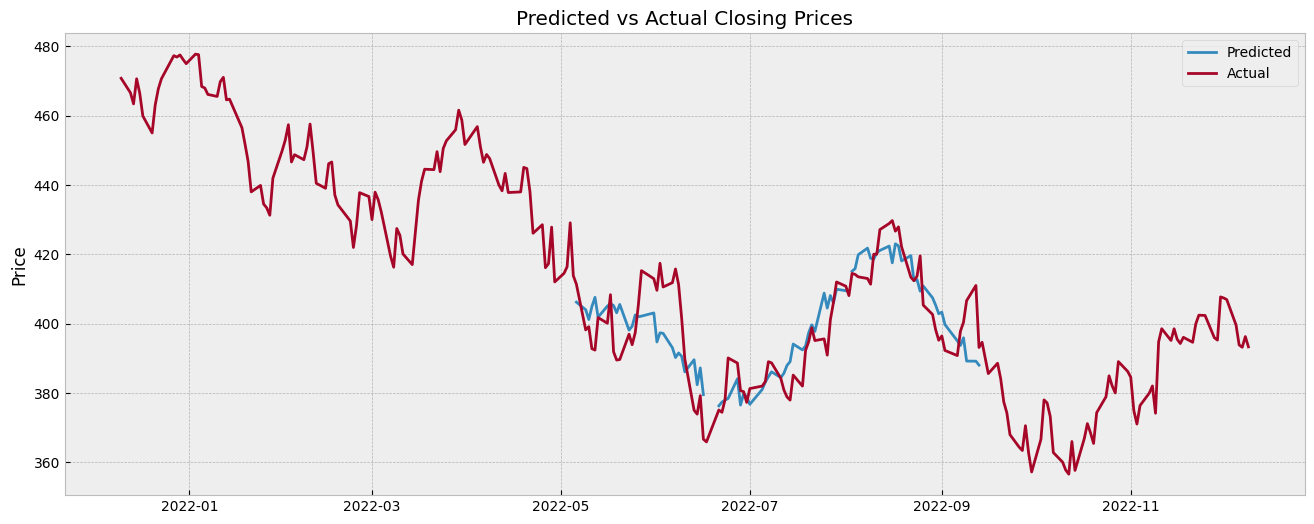

In [19]:
# Transforming the actual values to their original price
actual = pd.DataFrame(close_scaler.inverse_transform(df[["Close"]]),
                      index=df.index,
                      columns=[df.columns[0]])

# Getting a DF of the predicted values to validate against
predictions = validater(n_per_in, n_per_out)

# Printing the RMSE
print("RMSE:", val_rmse(actual, predictions))

# Plotting
plt.figure(figsize=(16,6))

# Plotting those predictions
plt.plot(predictions, label='Predicted')

# Plotting the actual values
plt.plot(actual, label='Actual')

plt.title(f"Predicted vs Actual Closing Prices")
plt.ylabel("Price")
plt.legend()
plt.xlim('2018-12', '2022-12')
plt.show()